# 1. Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load dataset

In [2]:
# Load the dataset
df = pd.read_csv("crime_dataset.csv")

In [3]:
# Load lookup tables
crime_types = pd.read_csv("crime_types.csv")
weapon_types = pd.read_csv("weapon_types.csv")

# 3. Data Cleaning

In [4]:
# 🔹 2. Handle date columns (keep and transform)
df['date_reported'] = pd.to_datetime(df['date_reported'], errors='coerce')
df['date_occurred'] = pd.to_datetime(df['date_occurred'], errors='coerce')

# Extract features from date_reported
df['report_year'] = df['date_reported'].dt.year
df['report_month'] = df['date_reported'].dt.month
df['report_day'] = df['date_reported'].dt.day
df['report_hour'] = df['date_reported'].dt.hour

# Extract features from date_occurred
df['occur_year'] = df['date_occurred'].dt.year
df['occur_month'] = df['date_occurred'].dt.month
df['occur_day'] = df['date_occurred'].dt.day
df['occur_hour'] = df['date_occurred'].dt.hour

# Optional: Keep a separate copy for plotting
df_plot = df.copy()

# Drop original datetime columns (now represented numerically)
df.drop(columns=['date_reported', 'date_occurred'], inplace=True)

In [5]:
# Display the shape and first few rows of each
print(" Crime Data:")
print(df.shape)
display(df.head())

print("\n Crime Types Lookup:")
print(crime_types.shape)
display(crime_types.head())

print("\n Weapon Types Lookup:")
print(weapon_types.shape)
display(weapon_types.head())

 Crime Data:
(203089, 31)


,division_number,area,area_name,reporting_district,part,crime_code,modus_operandi,victim_age,victim_gender,victim_ethnicity,...,longitude,case_solved,report_year,report_month,report_day,report_hour,occur_year,occur_month,occur_day,occur_hour
0,211414090,14,Pacific,1464,1,480,344,32.0,M,W,...,-118.4092,Not solved,2021,6,27,0,2021,6,20,20
1,210504861,5,Harbor,515,1,510,NaN,0.0,NaN,NaN,...,-118.2710,Solved,2021,1,22,0,2021,1,21,22
2,210104843,1,Central,139,1,510,NaN,0.0,NaN,NaN,...,-118.2326,Solved,2021,1,21,0,2021,1,21,2
3,210115564,1,Central,151,1,350,1308 0344 0345 1822,29.0,M,W,...,-118.2603,Not solved,2021,8,22,0,2021,8,22,7
4,211421187,14,Pacific,1465,1,510,NaN,0.0,NaN,NaN,...,-118.4022,Not solved,2021,11,9,0,2021,11,7,19



 Crime Types Lookup:
(133, 2)


,crime_code,crime_description
0,480,BIKE - STOLEN
1,510,VEHICLE - STOLEN
2,350,"THEFT, PERSON"
3,440,THEFT PLAIN - PETTY ($950 & UNDER)
4,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)



 Weapon Types Lookup:
(73, 2)


,weapon_code,weapon_description
0,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
1,500,UNKNOWN WEAPON/OTHER WEAPON
2,102,HAND GUN
3,201,KNIFE WITH BLADE OVER 6 INCHES IN LENGTH
4,107,OTHER FIREARM


In [6]:
# Check for missing values in each column
missing_values = df.isnull().sum().sort_values(ascending=False)

# Show only columns with missing values
missing_values = missing_values[missing_values > 0]

print("Missing Values Per Column:")
print(missing_values)

Missing Values Per Column:
crime_code_4           203071
crime_code_3           202560
crime_code_2           187239
cross_street           167414
weapon_code            131843
modus_operandi          28929
victim_ethnicity        27731
victim_gender           27729
victim_age               4062
premise_description        92
premise_code                3
crime_code_1                2
dtype: int64


In [7]:
print(df[['report_year', 'report_month', 'report_day', 'report_hour',
          'occur_year', 'occur_month', 'occur_day', 'occur_hour']].isnull().sum())

report_year     0
report_month    0
report_day      0
report_hour     0
occur_year      0
occur_month     0
occur_day       0
occur_hour      0
dtype: int64


# 3.1 Drop Irrelevant colums

In [8]:
# Drop irrelevant or highly missing columns
columns_to_drop = [
    'division_number', 'modus_operandi',
    'crime_code_2', 'crime_code_3', 'crime_code_4', 'cross_street', 'location'
]
df.drop(columns=columns_to_drop, inplace=True)

# Drop rows where target is missing
df.dropna(subset=['case_solved'], inplace=True)

# 3.2 Handle Missing values

In [9]:
# Fill categorical columns with 'Unknown'
df['victim_gender'] = df['victim_gender'].fillna('Unknown')
df['victim_ethnicity'] = df['victim_ethnicity'].fillna('Unknown')
df['premise_description'] = df['premise_description'].fillna('Unknown')

# Fill numerical columns
df['victim_age'] = df['victim_age'].fillna(df['victim_age'].median())
df['premise_code'] = df['premise_code'].fillna(df['premise_code'].mode()[0])
df['weapon_code'] = df['weapon_code'].fillna(-1)  # Placeholder for 'Unknown'

print("Moderate missing values handled.")

Moderate missing values handled.


In [10]:
# Drop rows with missing crime_code_1
df.dropna(subset=['crime_code_1'], inplace=True)

print("Dropped rows with missing crime_code_1.")
print("Current shape of dataset:", df.shape)

Dropped rows with missing crime_code_1.
Current shape of dataset: (203087, 24)


# 3.3 Duplicate Value

In [11]:
# Check for full duplicate rows
duplicate_rows = df.duplicated()

# Count and preview
num_duplicates = duplicate_rows.sum()
print(f" Number of fully duplicated rows: {num_duplicates}")

# Optionally view them (if needed)
if num_duplicates > 0:
    display(df[duplicate_rows].head())

 Number of fully duplicated rows: 718


,area,area_name,reporting_district,part,crime_code,victim_age,victim_gender,victim_ethnicity,premise_code,premise_description,...,longitude,case_solved,report_year,report_month,report_day,report_hour,occur_year,occur_month,occur_day,occur_hour
677,15,N Hollywood,1545,1,310,0.0,M,O,210.0,RESTAURANT/FAST FOOD,...,-118.3965,Not solved,2021,3,5,0,2021,3,5,3
7382,15,N Hollywood,1505,1,510,0.0,Unknown,Unknown,101.0,STREET,...,-118.3834,Not solved,2021,10,12,0,2021,10,11,23
9879,14,Pacific,1494,2,888,0.0,X,X,212.0,TRANSPORTATION FACILITY (AIRPORT),...,-118.4032,Not solved,2021,6,23,0,2021,6,23,23
11555,13,Newton,1395,2,624,69.0,F,H,102.0,SIDEWALK,...,-118.2652,Not solved,2021,9,8,0,2021,9,8,21
14767,19,Mission,1998,1,310,35.0,M,O,702.0,OFFICE BUILDING/OFFICE,...,-118.4488,Not solved,2021,3,19,0,2021,3,18,20


In [12]:
# Drop fully duplicated rows (all columns identical)
df.drop_duplicates(inplace=True)

# Confirm the shape after dropping
print("Shape after dropping duplicates:", df.shape)

Shape after dropping duplicates: (202369, 24)


# 3.4 Correct Data Type

In [13]:
# Convert numeric categorical columns to integers
df['premise_code'] = df['premise_code'].astype(int)
df['weapon_code'] = df['weapon_code'].astype(int)
df['crime_code_1'] = df['crime_code_1'].astype(int)
df['victim_age'] = df['victim_age'].astype(int)

print("All specified data types have been converted.")

All specified data types have been converted.


# 3.5 Normalize Data

In [14]:
# Normalize victim gender
df['victim_gender'] = df['victim_gender'].str.upper().map({
    'M': 'Male',
    'MALE': 'Male',
    'F': 'Female',
    'FEMALE': 'Female'
}).fillna('Unknown')

# Normalize victim ethnicity
ethnicity_map = {
    'W': 'White',
    'B': 'Black',
    'H': 'Hispanic',
    'A': 'Asian',
    'O': 'Other',
    'X': 'Unknown',
    'UNKNOWN': 'Unknown'
}
df['victim_ethnicity'] = df['victim_ethnicity'].str.upper().map(ethnicity_map).fillna('Unknown')

# Normalize case_solved
df['case_solved'] = df['case_solved'].str.strip().str.title()
df['case_solved'] = df['case_solved'].replace({'Not solved': 'Not Solved'})


# 4. EDA

# 4.1 merge Lookup Data

In [15]:
print("crime_types columns:", crime_types.columns.tolist())
print("weapon_types columns:", weapon_types.columns.tolist())

crime_types columns: ['crime_code', 'crime_description']
weapon_types columns: ['weapon_code', 'weapon_description']


In [16]:
# Merge with crime types
df = df.merge(crime_types, how='left', left_on='crime_code_1', right_on='crime_code')

# Merge with weapon types
df = df.merge(weapon_types, how='left', on='weapon_code')

# Check if merged columns are present
print("Columns after merging:", df.columns.tolist())



Columns after merging: ['area', 'area_name', 'reporting_district', 'part', 'crime_code_x', 'victim_age', 'victim_gender', 'victim_ethnicity', 'premise_code', 'premise_description', 'weapon_code', 'crime_code_1', 'incident_admincode', 'latitude', 'longitude', 'case_solved', 'report_year', 'report_month', 'report_day', 'report_hour', 'occur_year', 'occur_month', 'occur_day', 'occur_hour', 'crime_code_y', 'crime_description', 'weapon_description']


# 4.2 Rename Columns

In [17]:
# Rename only if columns exist
if 'crime_description' in df.columns:
    df.rename(columns={'crime_description': 'crime_type'}, inplace=True)
if 'weapon_description' in df.columns:
    df.rename(columns={'weapon_description': 'weapon_type'}, inplace=True)

# Drop original code columns if they still exist
columns_to_drop = [col for col in ['crime_code_1', 'crime_code'] if col in df.columns]
df.drop(columns=columns_to_drop, inplace=True)

# Confirm target columns exist now
print("Final columns:", df.columns.tolist())

Final columns: ['area', 'area_name', 'reporting_district', 'part', 'crime_code_x', 'victim_age', 'victim_gender', 'victim_ethnicity', 'premise_code', 'premise_description', 'weapon_code', 'incident_admincode', 'latitude', 'longitude', 'case_solved', 'report_year', 'report_month', 'report_day', 'report_hour', 'occur_year', 'occur_month', 'occur_day', 'occur_hour', 'crime_code_y', 'crime_type', 'weapon_type']


In [18]:
# Drop duplicate code columns
df.drop(columns=['crime_code_x', 'crime_code_y'], inplace=True)

# Final column check
print("✔ Final dataset columns:")
print(df.columns.tolist())

✔ Final dataset columns:
['area', 'area_name', 'reporting_district', 'part', 'victim_age', 'victim_gender', 'victim_ethnicity', 'premise_code', 'premise_description', 'weapon_code', 'incident_admincode', 'latitude', 'longitude', 'case_solved', 'report_year', 'report_month', 'report_day', 'report_hour', 'occur_year', 'occur_month', 'occur_day', 'occur_hour', 'crime_type', 'weapon_type']


# 4.3 Summery Statistics

In [19]:
# Basic statistical summary for numeric columns
print("=== Numerical Summary ===")
display(df.describe())

# Summary for categorical columns
print("\n=== Categorical Value Counts ===")
categorical_cols = ['victim_gender', 'victim_ethnicity', 'premise_description', 'weapon_type', 'crime_type', 'case_solved', 'area_name']

for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts(dropna=False))


=== Numerical Summary ===


,area,reporting_district,part,victim_age,premise_code,weapon_code,incident_admincode,latitude,longitude,report_year,report_month,report_day,report_hour,occur_year,occur_month,occur_day,occur_hour
count,202369.000000,202369.000000,202369.000000,202369.000000,202369.000000,202369.000000,202369.000000,202369.000000,202369.000000,202369.0,202369.000000,202369.000000,202369.0,202369.0,202369.000000,202369.000000,202369.000000
mean,10.750382,1121.448157,1.405363,30.054000,297.616087,125.200055,0.214351,33.826373,-117.497784,2021.0,6.776418,15.756855,0.0,2021.0,6.621335,15.531742,13.318448
std,6.061311,606.228063,0.490963,21.417572,216.191989,187.208198,0.410372,2.890692,10.034099,0.0,3.391261,8.788067,0.0,0.0,3.396832,8.846599,6.523773
min,1.000000,101.000000,1.000000,0.000000,101.000000,-1.000000,0.000000,0.000000,-118.667300,2021.0,1.000000,1.000000,0.0,2021.0,1.000000,1.000000,0.000000
25%,6.000000,628.000000,1.000000,15.000000,101.000000,-1.000000,0.000000,34.011100,-118.429100,2021.0,4.000000,8.000000,0.0,2021.0,4.000000,8.000000,9.000000
50%,11.000000,1144.000000,1.000000,31.000000,203.000000,-1.000000,0.000000,34.058100,-118.322500,2021.0,7.000000,16.000000,0.0,2021.0,7.000000,15.000000,14.000000
75%,16.000000,1612.000000,2.000000,45.000000,501.000000,400.000000,0.000000,34.161100,-118.274100,2021.0,10.000000,23.000000,0.0,2021.0,10.000000,23.000000,19.000000
max,21.000000,2199.000000,2.000000,99.000000,971.000000,516.000000,1.000000,34.334300,0.000000,2021.0,12.000000,31.000000,0.0,2021.0,12.000000,31.000000,23.000000



=== Categorical Value Counts ===

Value counts for victim_gender:
victim_gender
Male       85256
Female     73811
Unknown    43302
Name: count, dtype: int64

Value counts for victim_ethnicity:
victim_ethnicity
Hispanic    61590
Unknown     48859
White       42634
Black       29151
Other       15995
Asian        4140
Name: count, dtype: int64

Value counts for premise_description:
premise_description
STREET                                          52869
SINGLE FAMILY DWELLING                          32274
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    24135
PARKING LOT                                     15379
OTHER BUSINESS                                   9191
                                                ...  
BANKING INSIDE MARKET-STORE *                       1
ESCALATOR*                                          1
MTA - PURPLE LINE - CIVIC CENTER/GRAND PARK         1
MTA - ORANGE LINE - BALBOA                          1
MTA - PURPLE LINE - PERSHING SQUARE                 1
Na

In [20]:
(df['victim_age'] == 0).sum()

np.int64(48008)

In [21]:
median_age = df[df['victim_age'] > 0]['victim_age'].median()
df['victim_age'] = df['victim_age'].replace(0, median_age)

In [22]:
# Set style
sns.set(style="whitegrid")

# 4.4 Distribution

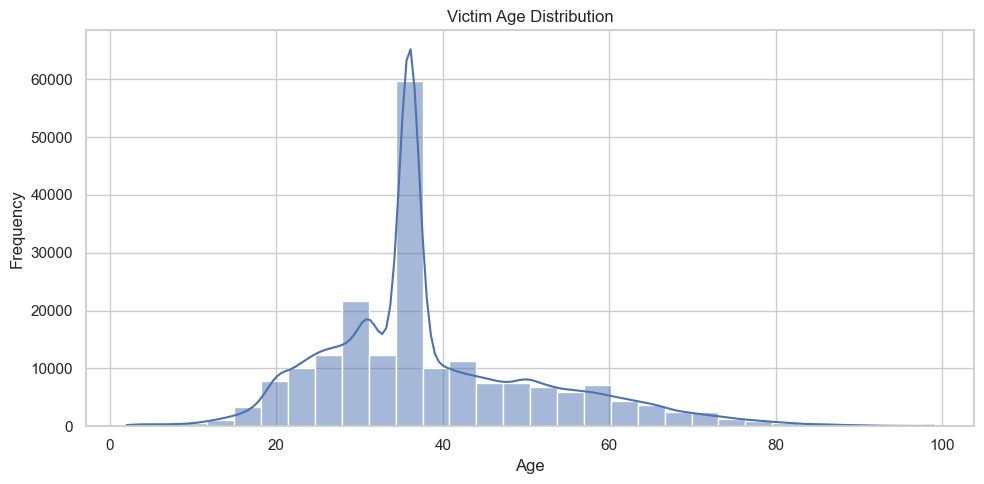

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(df['victim_age'], bins=30, kde=True)
plt.title('Victim Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

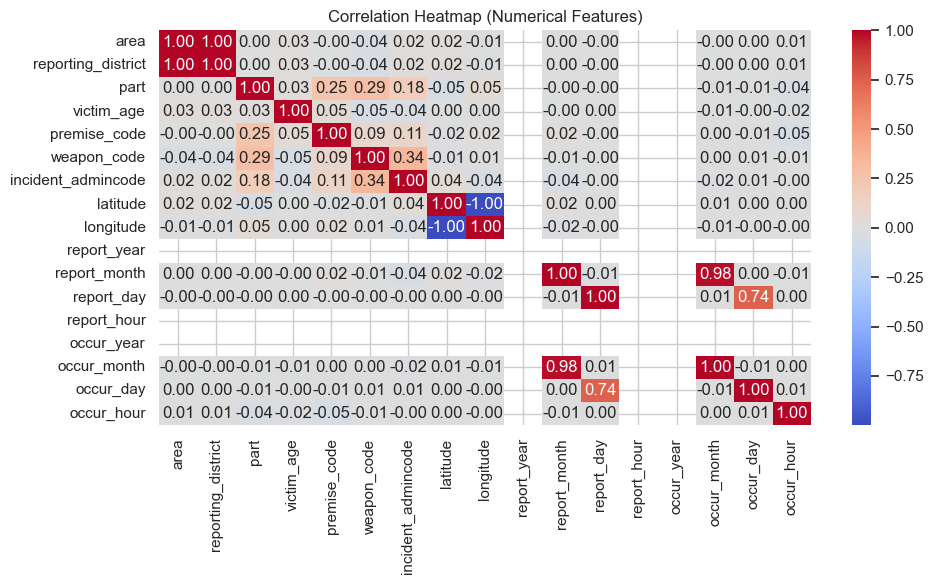

In [24]:
plt.figure(figsize=(10, 6))
numeric_cols = df.select_dtypes(include='number')
corr = numeric_cols.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap (Numerical Features)')
plt.tight_layout()
plt.show()

# 4.5 Solve Rate Visuals

C:\Users\faizm\AppData\Local\Temp\ipykernel_16900\2431060018.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='case_solved', palette='Set2')


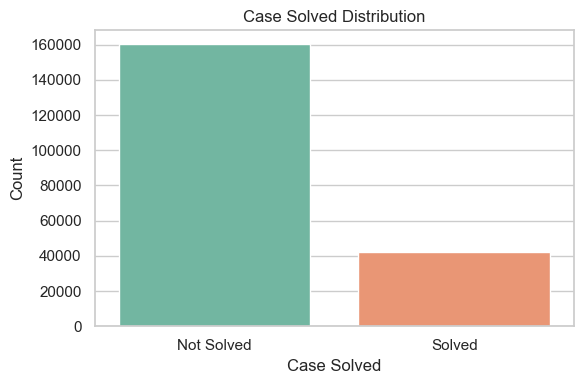

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='case_solved', palette='Set2')
plt.title('Case Solved Distribution')
plt.xlabel('Case Solved')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

C:\Users\faizm\AppData\Local\Temp\ipykernel_16900\1110450042.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


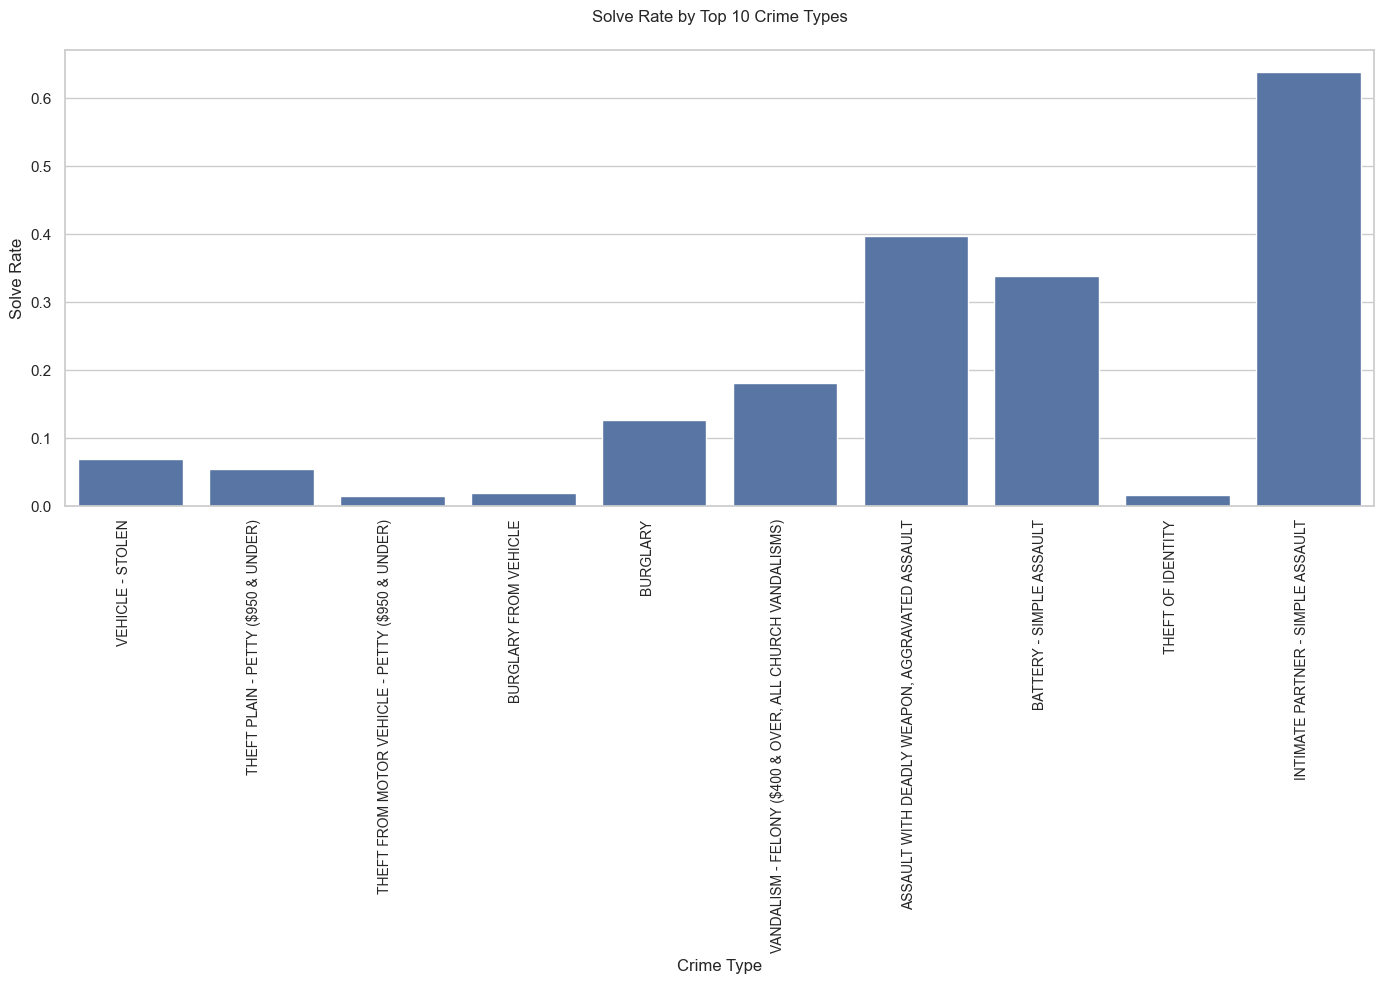

In [26]:
top_crimes = df['crime_type'].value_counts().head(10).index
crime_subset = df[df['crime_type'].isin(top_crimes)]

plt.figure(figsize=(14, 10))
sns.barplot(
    data=crime_subset,
    x='crime_type',
    y=crime_subset['case_solved'].apply(lambda x: 1 if x == 'Solved' else 0),
    estimator=lambda x: sum(x) / len(x),
    ci=None
)
plt.title('Solve Rate by Top 10 Crime Types', pad=20)
plt.ylabel('Solve Rate')
plt.xlabel('Crime Type')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\faizm\AppData\Local\Temp\ipykernel_16900\1375744056.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


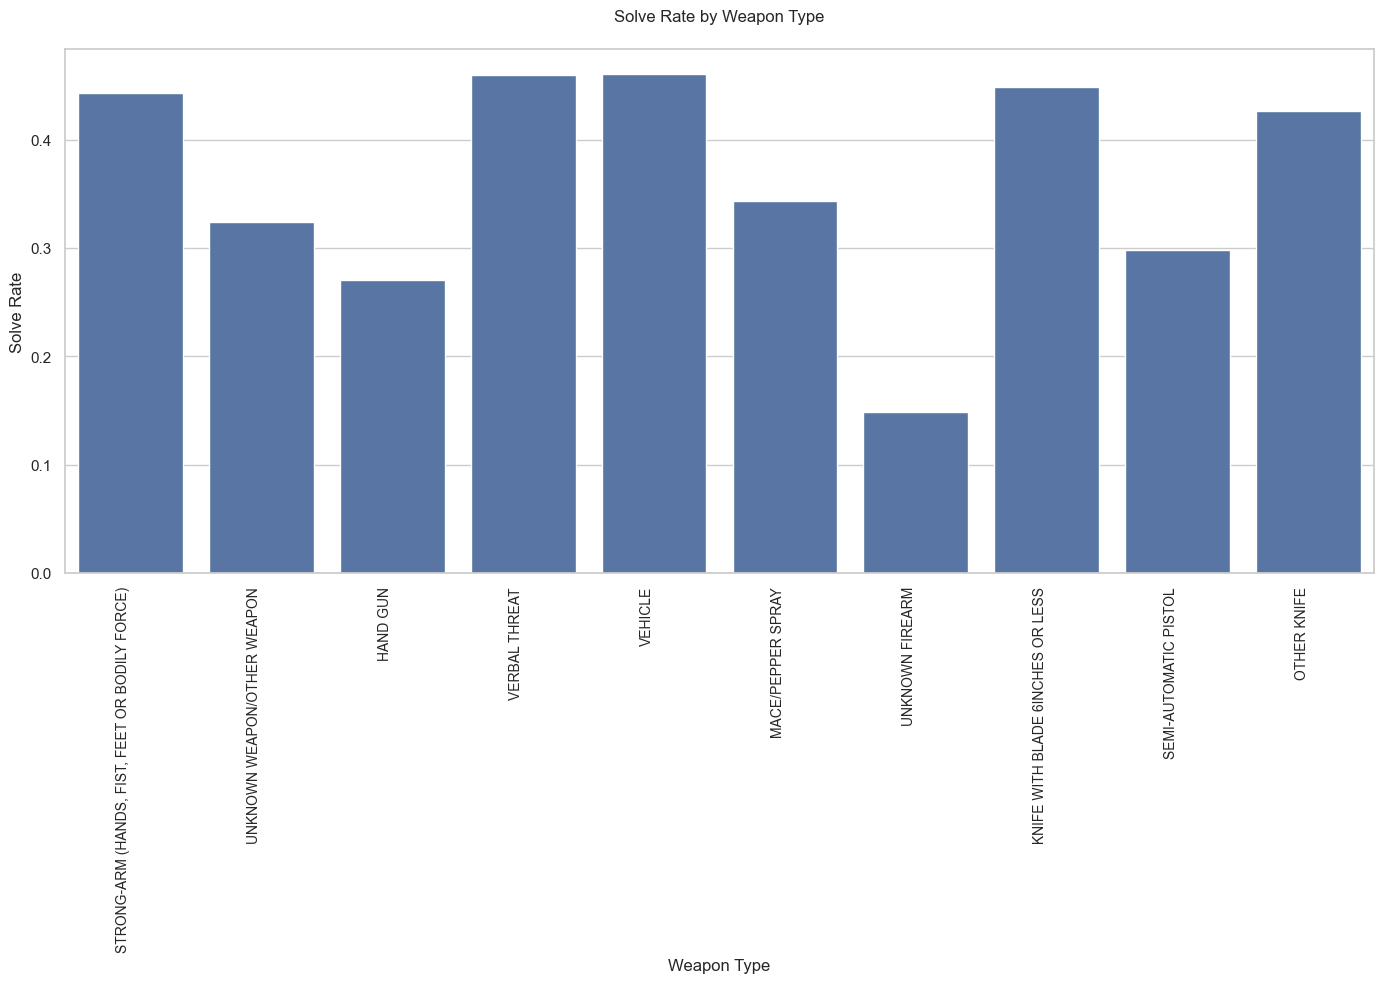

In [27]:
top_weapons = df['weapon_type'].value_counts().head(10).index
weapon_subset = df[df['weapon_type'].isin(top_weapons)]

plt.figure(figsize=(14, 10))
sns.barplot(
    data=weapon_subset,
    x='weapon_type',
    y=weapon_subset['case_solved'].apply(lambda x: 1 if x == 'Solved' else 0),
    estimator=lambda x: sum(x) / len(x),
    ci=None
)
plt.title('Solve Rate by Weapon Type', pad=20)
plt.ylabel('Solve Rate')
plt.xlabel('Weapon Type')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

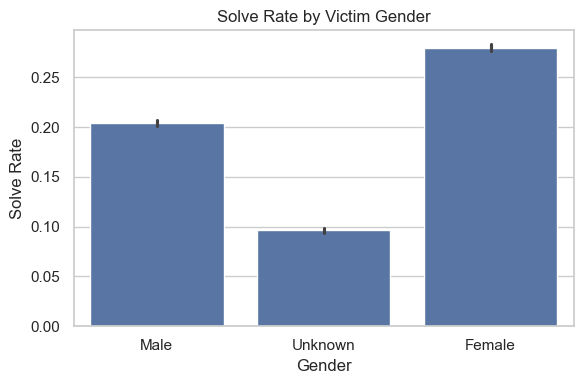

In [28]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df,
    x='victim_gender',
    y=df['case_solved'].apply(lambda x: 1 if x == 'Solved' else 0)
)
plt.title('Solve Rate by Victim Gender')
plt.ylabel('Solve Rate')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

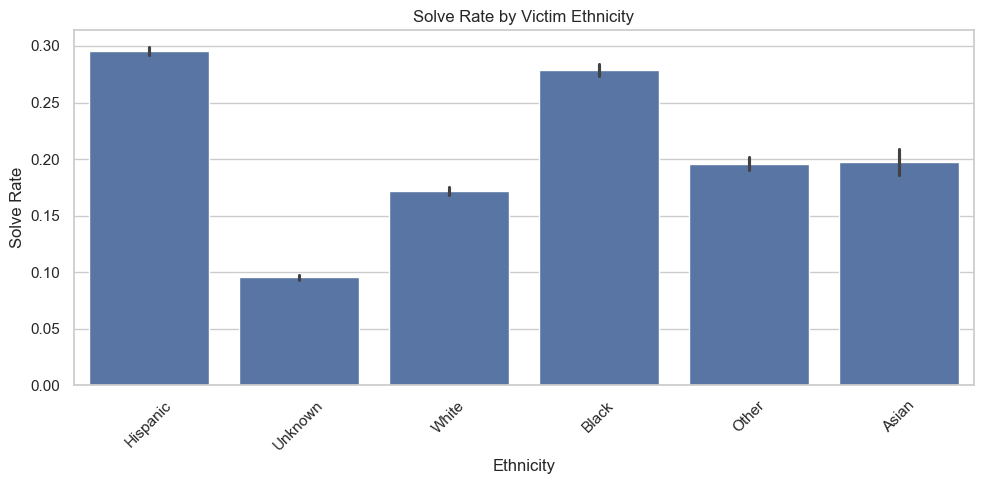

In [29]:
ethnic_order = df['victim_ethnicity'].value_counts().index

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df,
    x='victim_ethnicity',
    y=df['case_solved'].apply(lambda x: 1 if x == 'Solved' else 0),
    order=ethnic_order
)
plt.title('Solve Rate by Victim Ethnicity')
plt.ylabel('Solve Rate')
plt.xlabel('Ethnicity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.6 Solve rate by Location

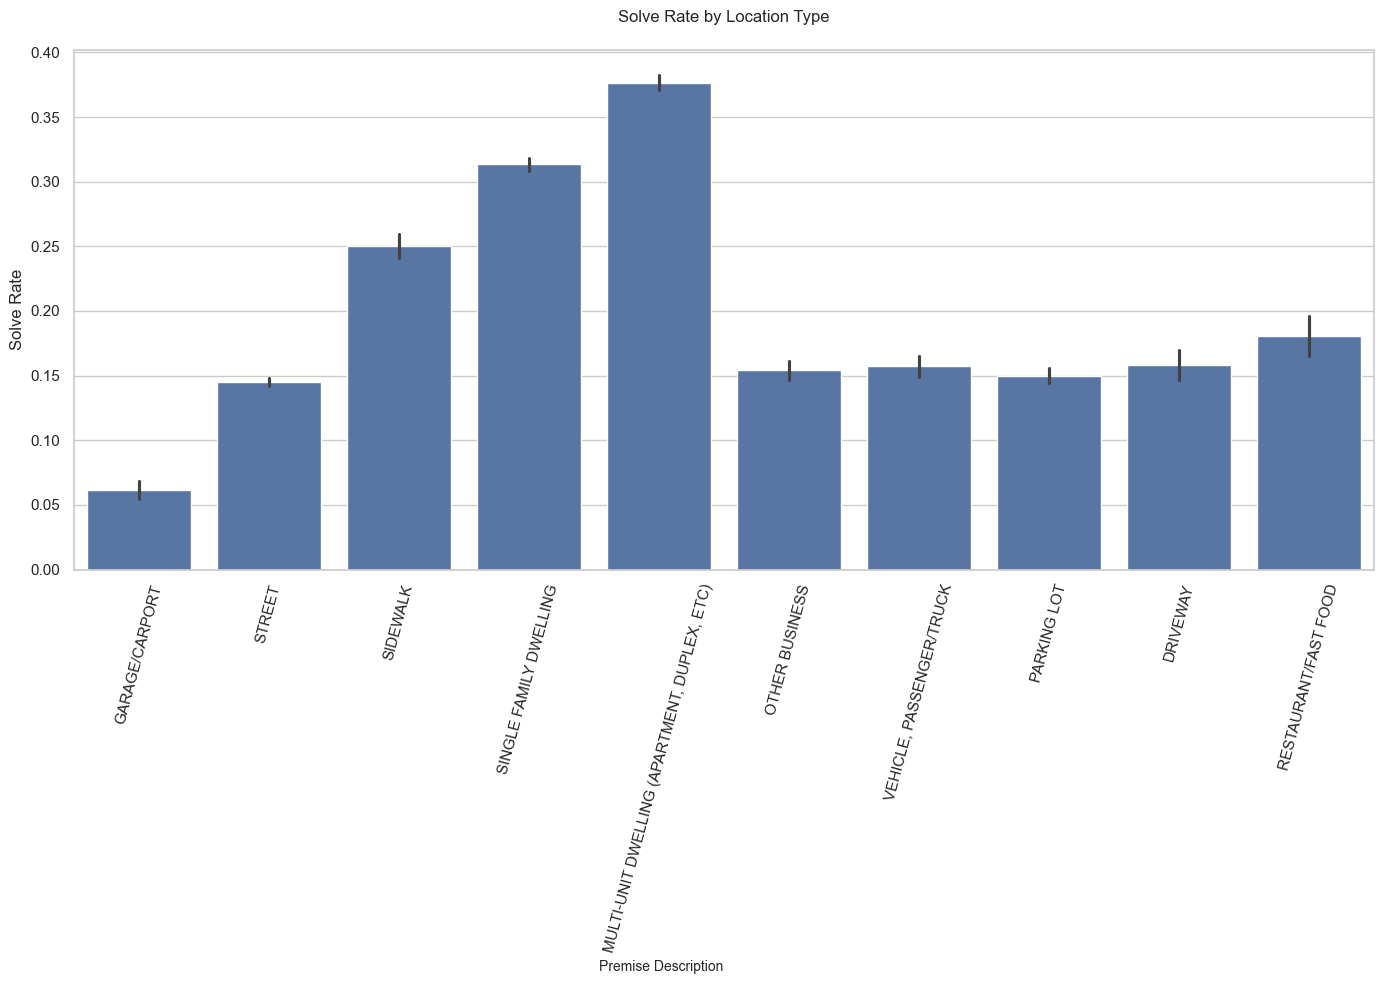

In [30]:
top_locations = df['premise_description'].value_counts().head(10).index
loc_subset = df[df['premise_description'].isin(top_locations)]

plt.figure(figsize=(14, 10))
sns.barplot(
    data=loc_subset,
    x='premise_description',
    y=loc_subset['case_solved'].apply(lambda x: 1 if x == 'Solved' else 0)
)
plt.title('Solve Rate by Location Type', pad=20)
plt.ylabel('Solve Rate')
plt.xlabel('Premise Description', ha='right', fontsize=10)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

# 5. Visualizations

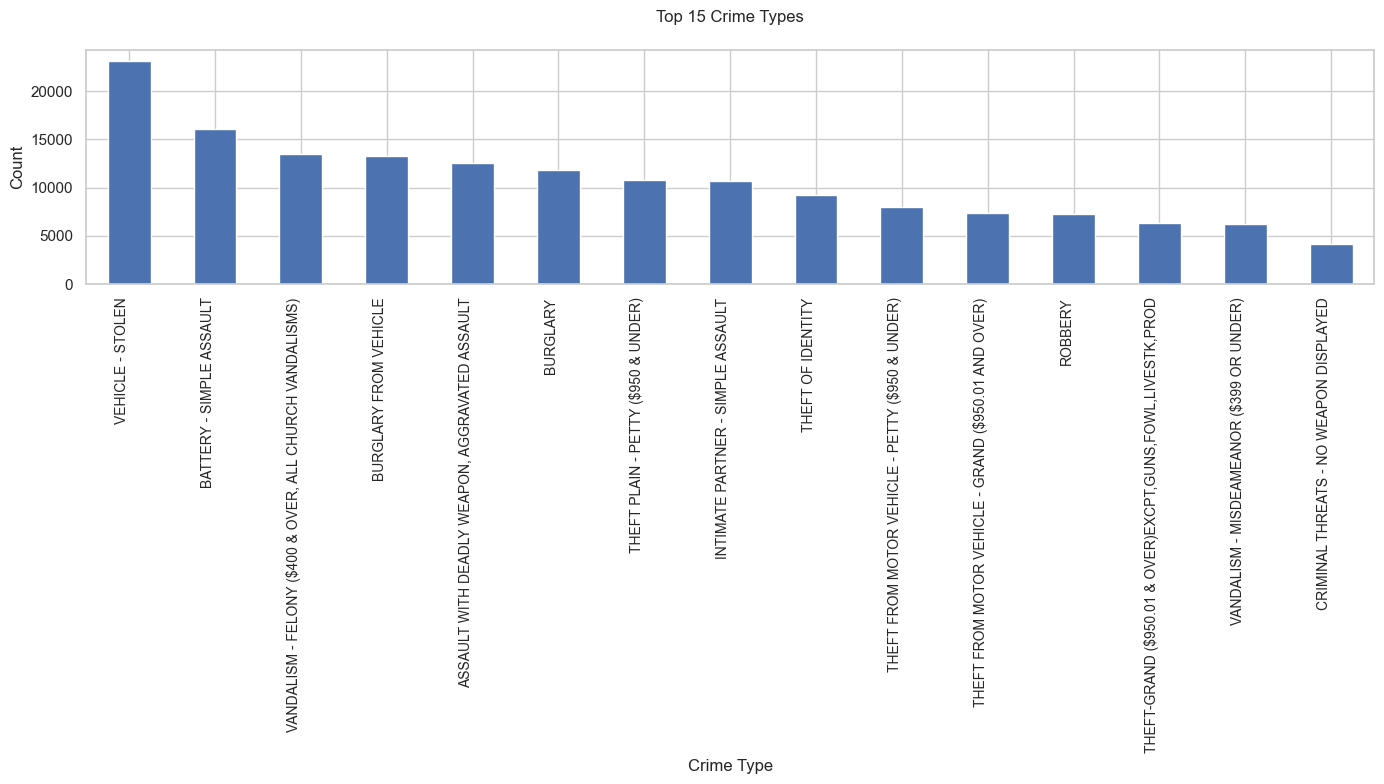

In [31]:
plt.figure(figsize=(14, 8))
df['crime_type'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Crime Types', pad=20)
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

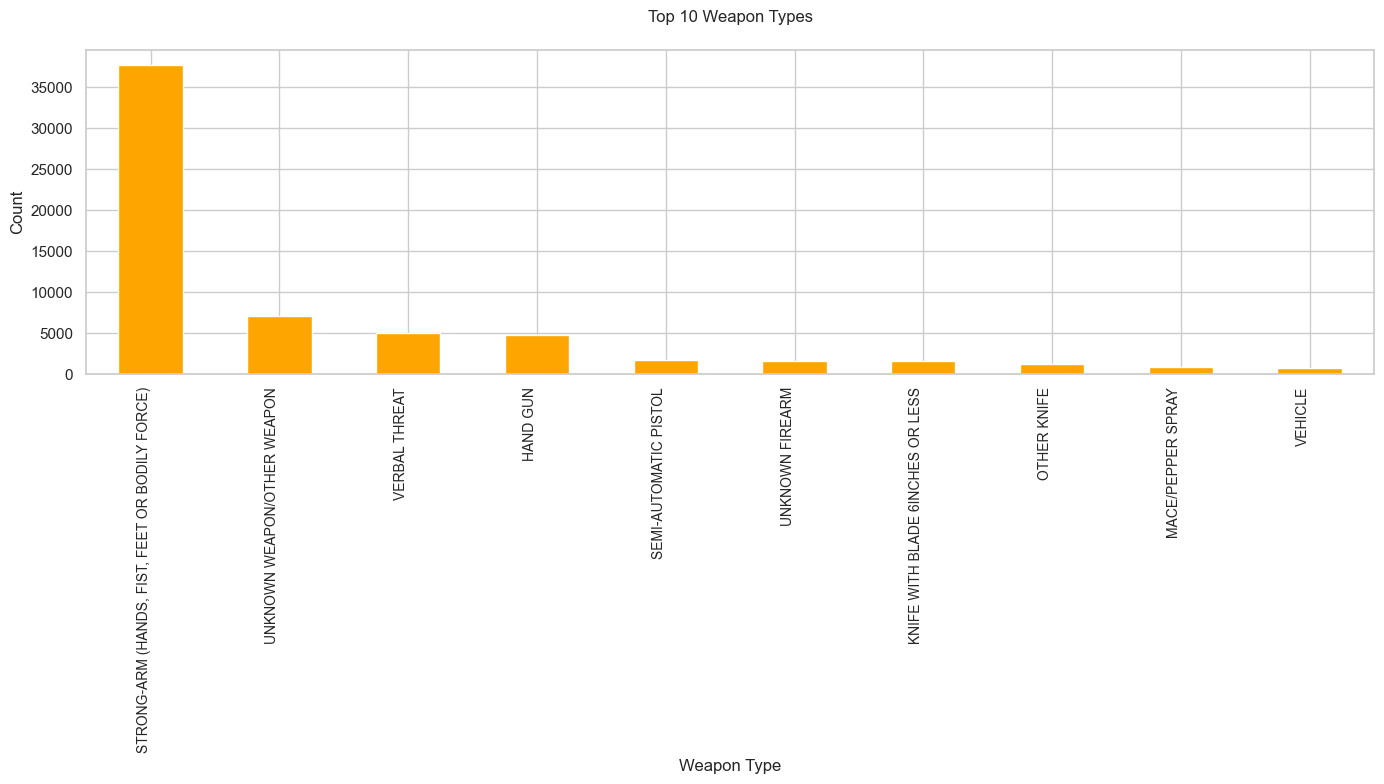

In [32]:
plt.figure(figsize=(14, 8))
df['weapon_type'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title('Top 10 Weapon Types', pad=20)
plt.xlabel('Weapon Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

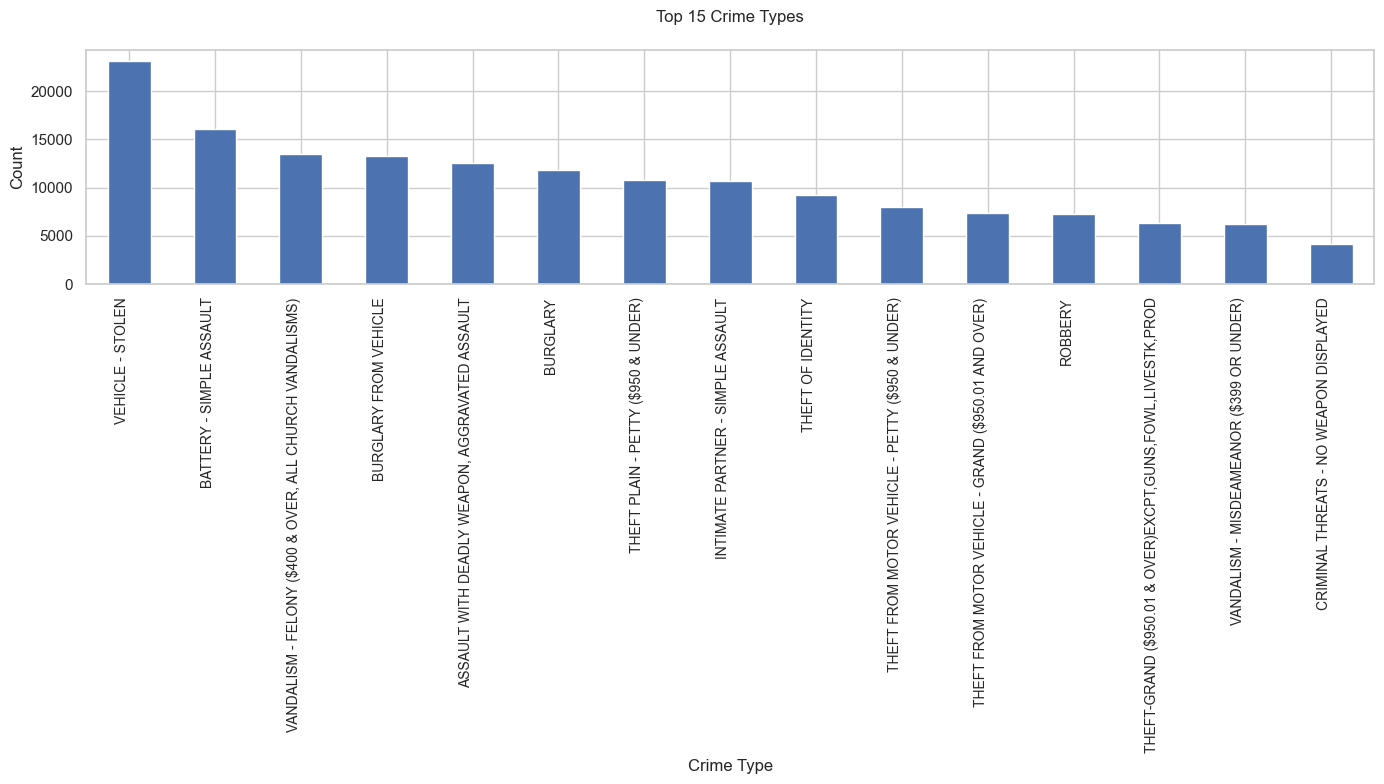

In [33]:
plt.figure(figsize=(14, 8))
df['crime_type'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Crime Types', pad=20)
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

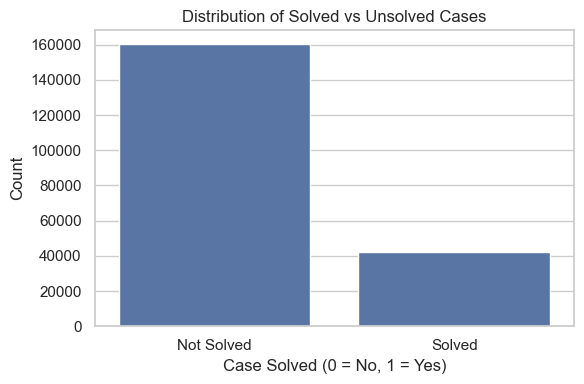

In [34]:
# Plot bar plot of case_solved counts
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='case_solved')
plt.title("Distribution of Solved vs Unsolved Cases")
plt.xlabel("Case Solved (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Solved', 'Solved'])
plt.tight_layout()
plt.show()

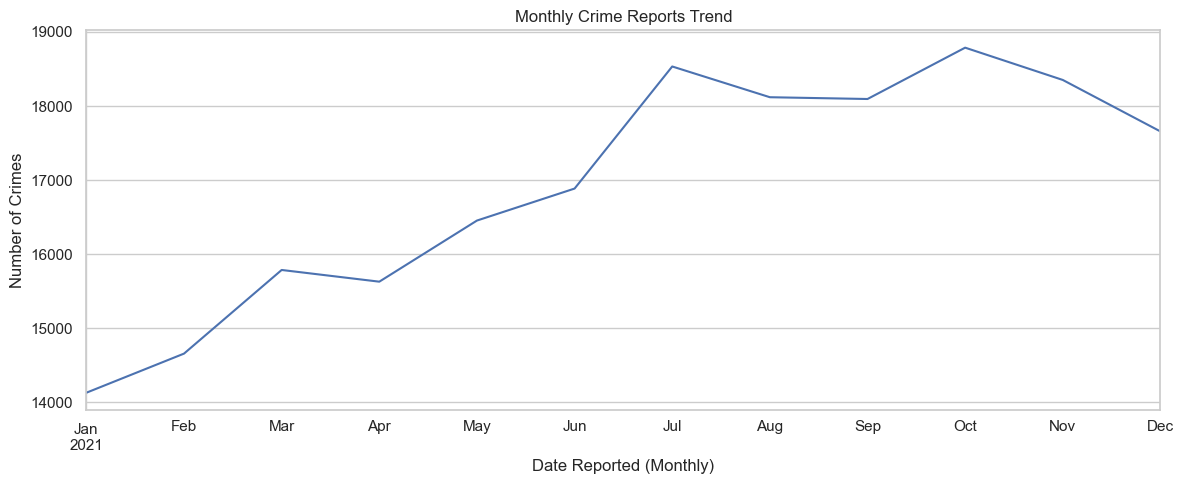

In [35]:
# Combine year and month
df_plot['report_date'] = pd.to_datetime(df_plot['report_year'].astype(str) + '-' + df_plot['report_month'].astype(str) + '-01')

# Group by month
monthly_trend = df_plot.groupby('report_date').size()

# Plot
plt.figure(figsize=(12, 5))
monthly_trend.plot()
plt.title("Monthly Crime Reports Trend")
plt.xlabel("Date Reported (Monthly)")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()


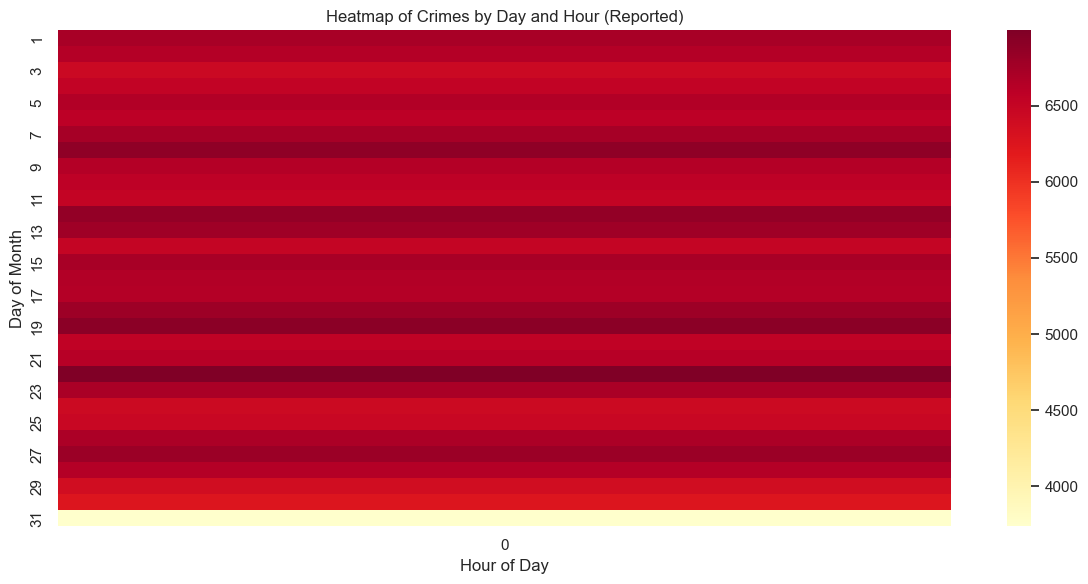

In [39]:
# Create pivot table
heatmap_data = df_plot.pivot_table(index='report_day', columns='report_hour', values='case_solved', aggfunc='count').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd")
plt.title("Heatmap of Crimes by Day and Hour (Reported)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Month")
plt.tight_layout()
plt.show()


C:\Users\faizm\AppData\Local\Temp\ipykernel_16900\1015450601.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x='report_hour', palette='coolwarm')


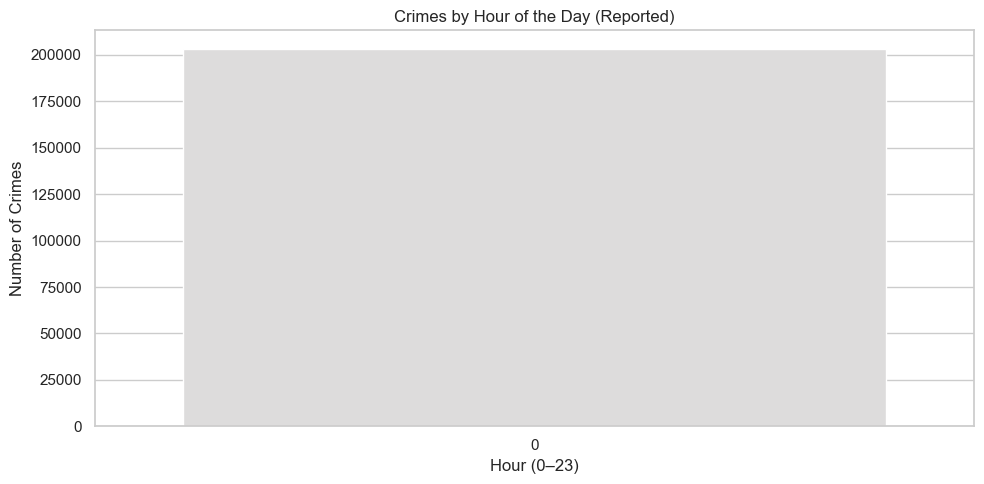

In [40]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_plot, x='report_hour', palette='coolwarm')
plt.title("Crimes by Hour of the Day (Reported)")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Crimes")
plt.tight_layout()
plt.show()


# 6. Feature Engineering

Data has already been normalized
next feature engineering will happen just before the logistic regression when we will do scaling

# 6.1 Encode All Categorical Columns

In [41]:
# Encode all categorical columns
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 7. Model Building

# 7.1 Random Forest 

In [42]:
# Split into features and target
#drop_cols = ['case_solved', 'incident_admincode', 'latitude', 'longitude']
#drop_cols = ['case_solved', 'incident_admincode', 'latitude', 'longitude', 'area']
#drop_cols = ['case_solved', 'incident_admincode', 'latitude', 'longitude', 'area', 'report_month']
drop_cols = ['case_solved', 'incident_admincode', 'latitude', 'longitude', 'area', 'report_month', 'victim_gender']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['case_solved']

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# try different hypertuning
# max_depth=10,
# max_depth=20,
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)
# different Threshold
# threshold=0.45
# threshold = 0.55
# threshold = 0.60
# threshold = 0.65
#threshold = 0.6 
#_pred_thresh = (y_proba >= threshold).astype(int)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 7.2 Random forest Evalution

In [44]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[25663  6362]
 [ 2320  6129]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     32025
           1       0.49      0.73      0.59      8449

    accuracy                           0.79     40474
   macro avg       0.70      0.76      0.72     40474
weighted avg       0.83      0.79      0.80     40474

Accuracy: 0.78549192073924
AUC-ROC Score: 0.8450876633267022


In [45]:
train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print(f"Train Accuracy: {train_acc:.4f}")

test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8281
Test Accuracy: 0.7855


from sklearn.metrics import precision_score, recall_score

print("\n📊 Threshold Sweep:")
for t in np.arange(0.4, 0.8, 0.05):
    preds = (y_proba >= t).astype(int)
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    print(f"Threshold: {t:.2f} → Precision: {p:.2f}, Recall: {r:.2f}")


train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print(f"Train Accuracy: {train_acc:.4f}")

test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_acc:.4f}")


Train predictions using threshold
train_proba = model.predict_proba(X_train)[:, 1]
train_pred_thresh = (train_proba >= threshold).astype(int)
train_acc = accuracy_score(y_train, train_pred_thresh)
print(f"Train Accuracy (threshold={threshold}): {train_acc:.4f}")

Test predictions using threshold
test_pred_thresh = (y_proba >= threshold).astype(int)
test_acc = accuracy_score(y_test, test_pred_thresh)
print(f"Test Accuracy (threshold={threshold}): {test_acc:.4f}")


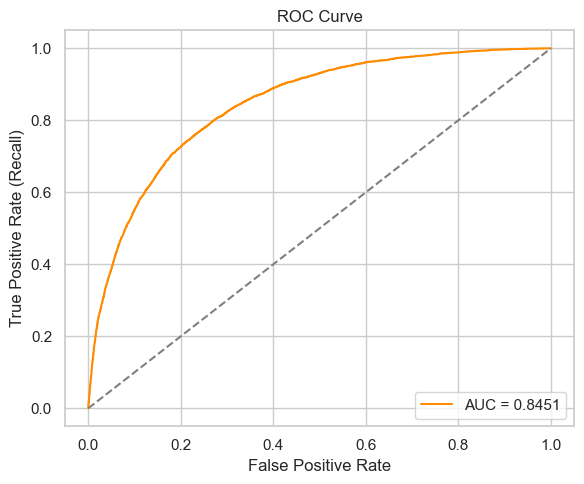

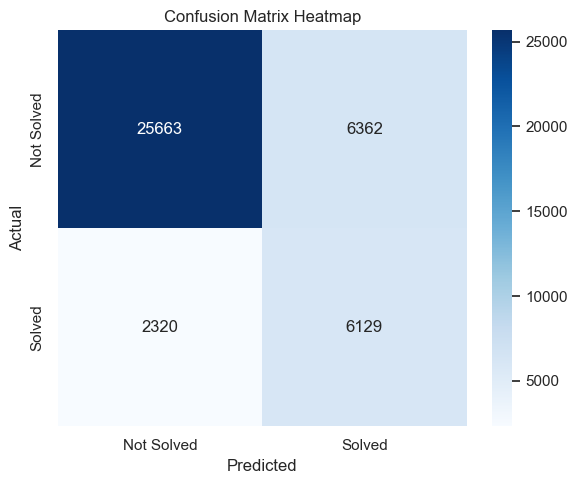

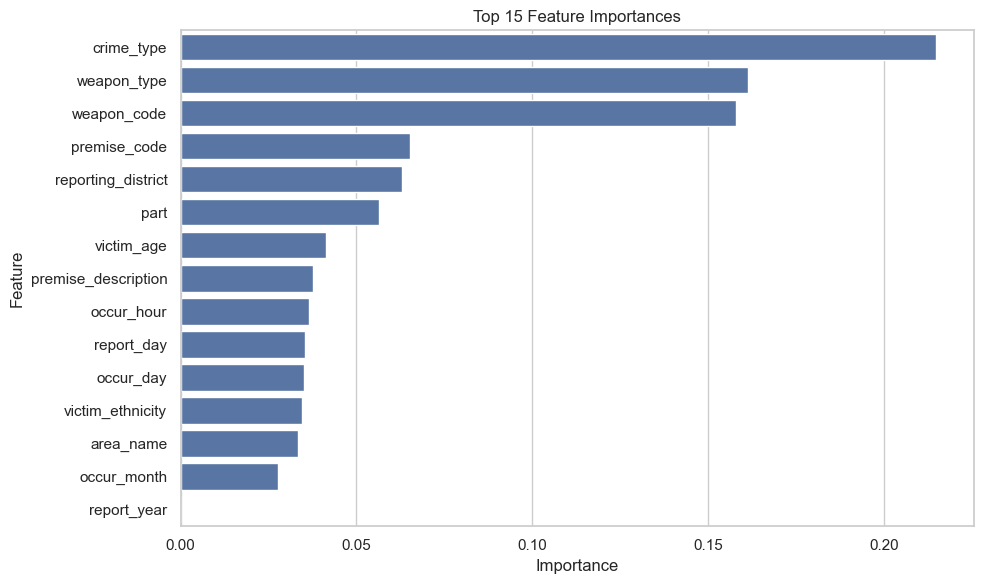

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues',
            xticklabels=['Not Solved', 'Solved'],
            yticklabels=['Not Solved', 'Solved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

# --- 8. Feature Importances ---
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# 7.3 Logistic Regression 

# 6.2 Scale Features

In [47]:
# Split into features and target
#drop_cols = ['case_solved', 'incident_admincode', 'latitude', 'longitude', 'area', 'report_month', 'weapon_type']
drop_cols = ['case_solved', 'incident_admincode', 'latitude', 'longitude']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['case_solved']

In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

model.fit(X_train_scaled, y_train)

y_pred_logi = model.predict(X_test_scaled)
y_proba_logi = model.predict_proba(X_test_scaled)[:,1]

# 7.4 Logistic Regression Evaluation

In [50]:
# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logi))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logi))

print("Accuracy:", accuracy_score(y_test, y_pred_logi))
# 🔹 11. AUC-ROC
auc = roc_auc_score(y_test, y_proba_logi)
print(f"\nAUC-ROC Score: {auc:.4f}")


Confusion Matrix:
[[22929  9096]
 [ 1987  6462]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     32025
           1       0.42      0.76      0.54      8449

    accuracy                           0.73     40474
   macro avg       0.67      0.74      0.67     40474
weighted avg       0.81      0.73      0.75     40474

Accuracy: 0.726169886840935

AUC-ROC Score: 0.8019


In [51]:
# Train accuracy
train_pred_logi = model.predict(X_train_scaled)
train_acc_logi = accuracy_score(y_train, train_pred_logi)

# Test accuracy (already done, but repeat here for comparison)
test_acc_logi = accuracy_score(y_test, y_pred_logi)

print(f"\nTrain Accuracy: {train_acc_logi:.4f}")
print(f"Test Accuracy: {test_acc_logi:.4f}")


Train Accuracy: 0.7249
Test Accuracy: 0.7262


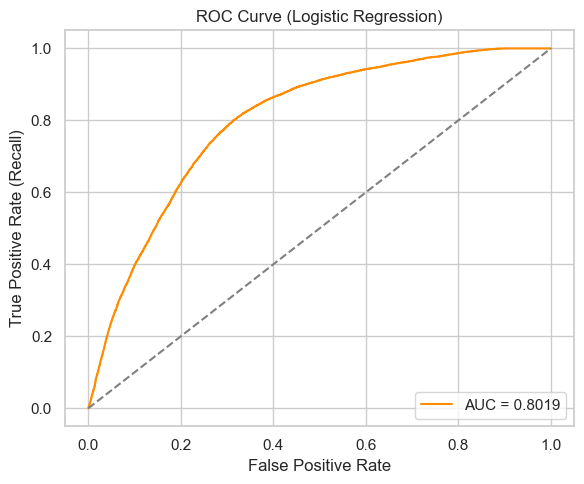

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_logi)

# ROC Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

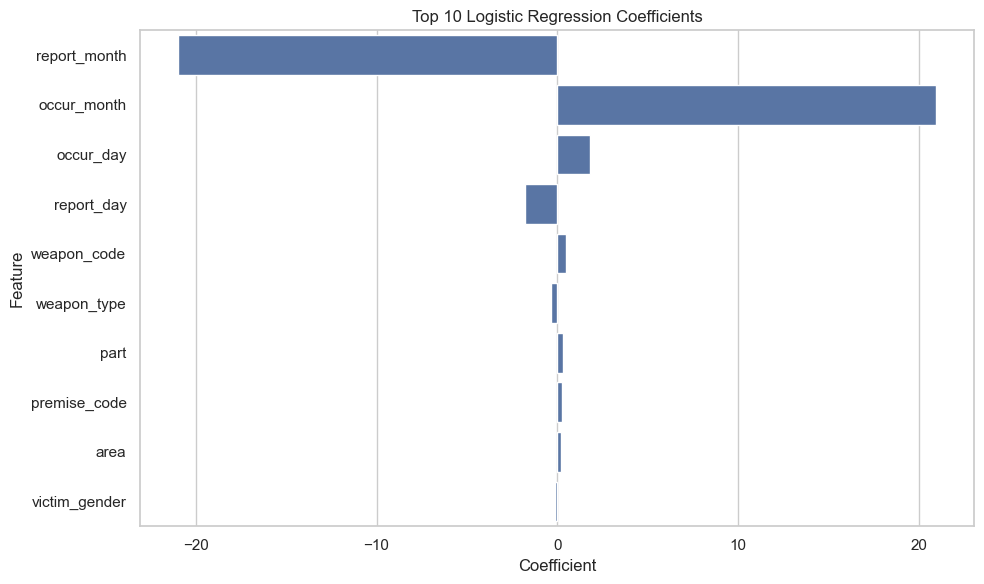

In [53]:
# Optional: visualize coefficients
import numpy as np

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
plt.title("Top 10 Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

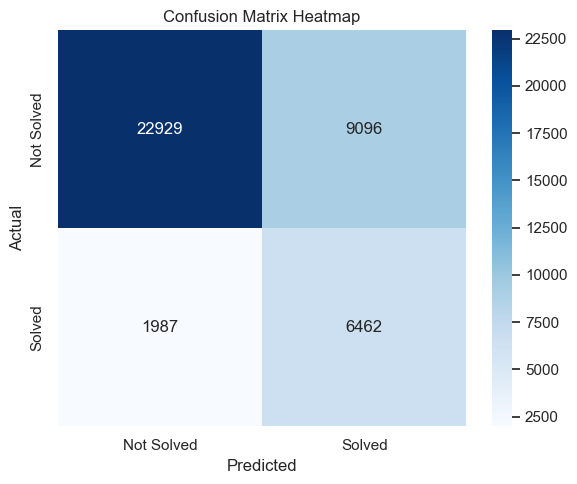

In [54]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_logi)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Not Solved', 'Solved'], yticklabels=['Not Solved', 'Solved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

# The End